## Introduction

This notebook presents the exploratory data analysis (EDA) and visualization component of a project that aims to predict whether a customer will recommend a product based on their review. The dataset contains customer feedback from an e-commerce clothing retailer. The insights gained from this analysis will guide the development of a binary classification model to predict product recommendations.

## Load libraries and Inspect Data

We begin by loading the dataset and performing an initial inspection to understand the structure, column names, and types of data we are dealing with.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer


df = pd.read_csv("C:/Users/Bhupender/Desktop/Assignments/Sem 4/RR/New folder/Predictive-Analysis-Ecommerce/Data/Womens Clothing E-Commerce Reviews.csv")  # Ensure the file is in the same directory as the notebook

In [4]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## Clean data

This step includes removing duplicates, standardizing column names for ease of use, and stripping whitespace from text entrieg.

In [5]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df.drop_duplicates(inplace=True)

In [6]:
df = df[(df['age'] > 0) & (df['age'] < 100)]
df = df[df['rating'].between(1, 5)]

## Handling Missing Values

We drop rows with missing values in essential columns such as 'review_text' and 'recommended_ind', which are critical for the prediction task. For less essential text fields like 'title', we impute missing values with empty strings to maintain consistency.

In [7]:
df = df.dropna(subset=['review_text', 'recommended_ind'])
df['title'] = df['title'].fillna('')

# Analyze Distributions

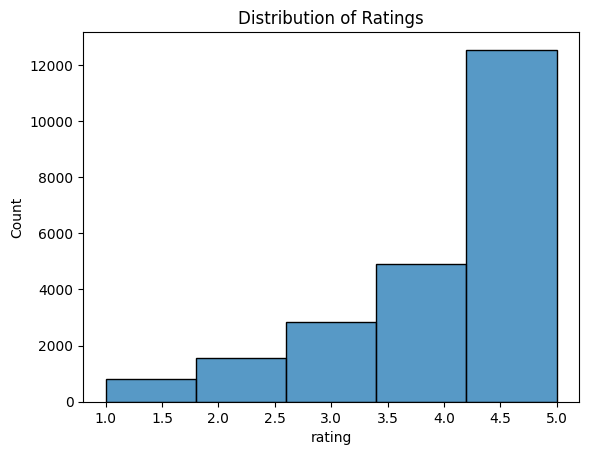

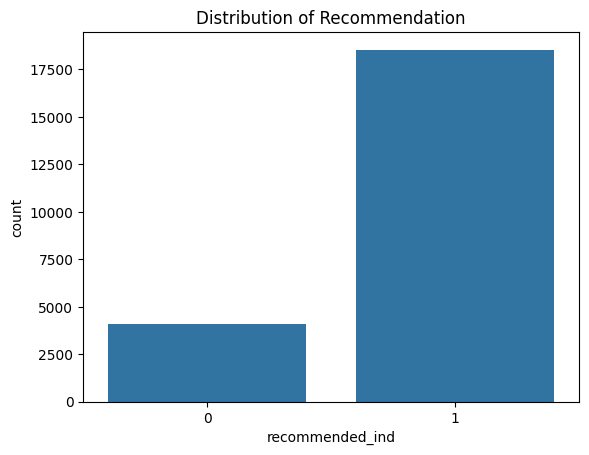

In [8]:
# Histogram for a numerical feature
sns.histplot(df['rating'], bins=5)
plt.title('Distribution of Ratings')
plt.show()

# Count plot for categorical feature
sns.countplot(x='recommended_ind', data=df)
plt.title('Distribution of Recommendation')
plt.show()


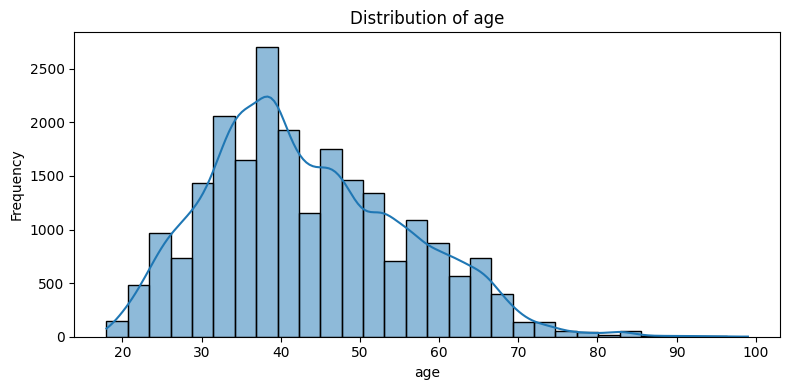

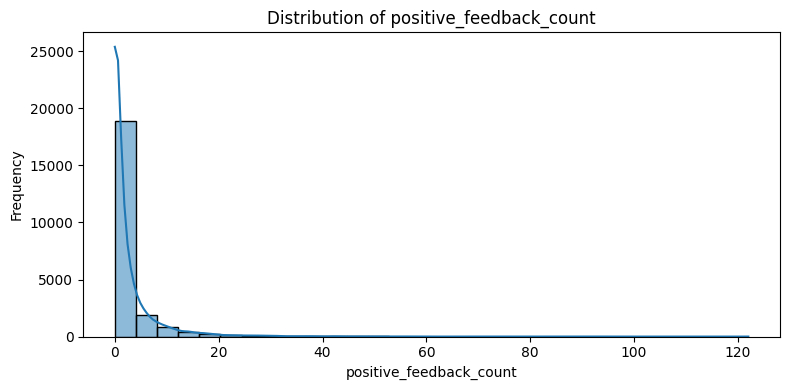

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['age', 'positive_feedback_count']
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


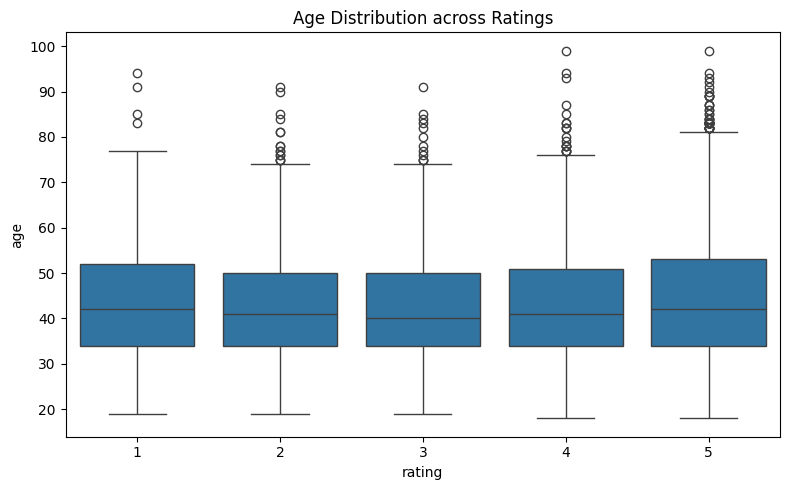

In [10]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='rating', y='age', data=df)
plt.title('Age Distribution across Ratings')
plt.tight_layout()
plt.show()


## Explore feature relationships

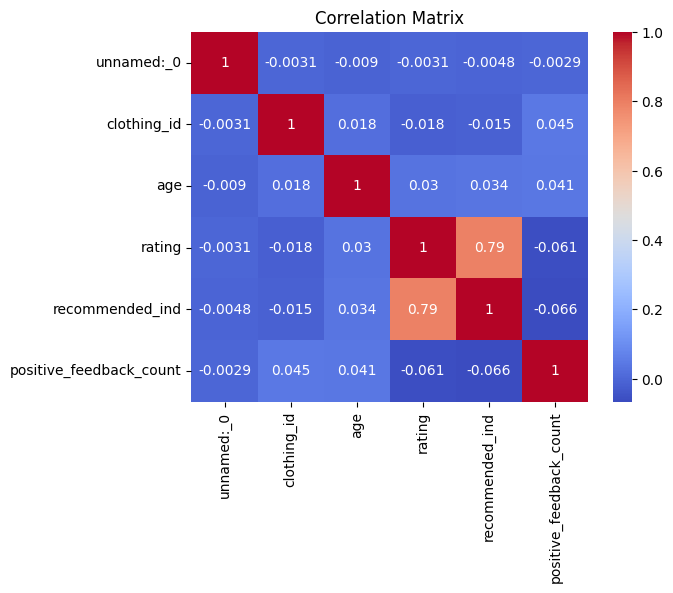

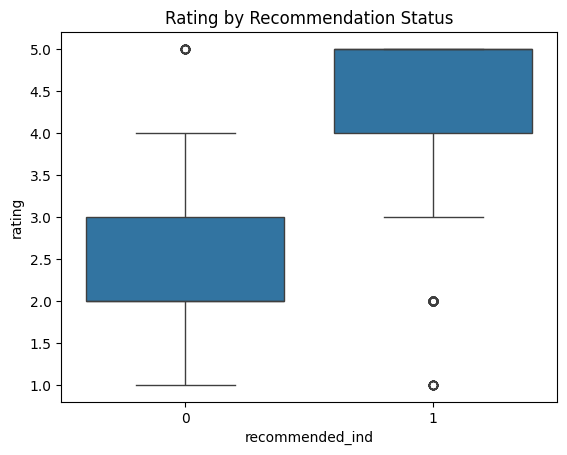

In [11]:
# Ensure only numeric columns are used for correlation
numeric_df = df.select_dtypes(include=['number']).dropna()

# Correlation heatmap
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Boxplot by target
sns.boxplot(x='recommended_ind', y='rating', data=df)
plt.title('Rating by Recommendation Status')
plt.show()


## Exploratory Data Analysis (EDA)

We conduct statistical analysis and visualizations to understand key characteristics of the data. This includes:

- Distribution of the target variable (`recommended_ind`)
- Relationship between age and recommendations
- Frequency of feedback across product categories
- Word clouds to visualize common themes in positive and negative reviews

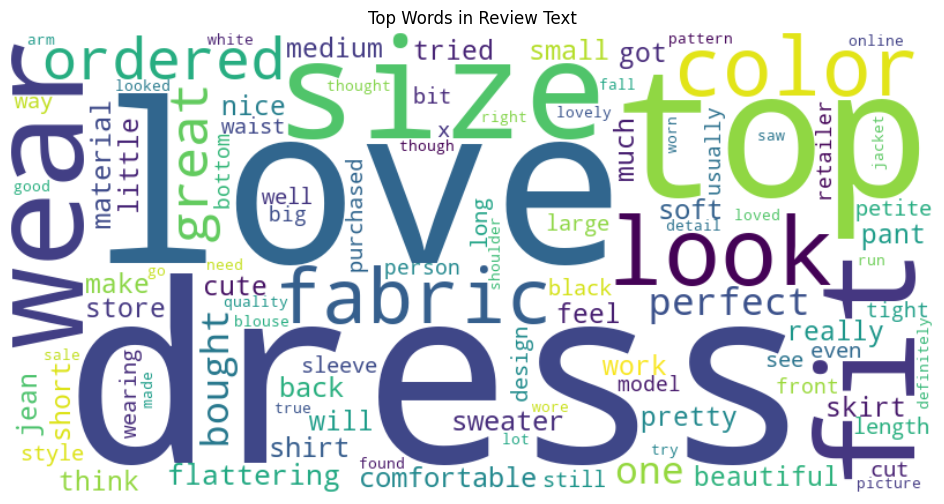

In [12]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# remove missing values
text_data = df['review_text'].dropna()

combined_text = " ".join(text_data)

# Tạo Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(combined_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Words in Review Text")
plt.show()


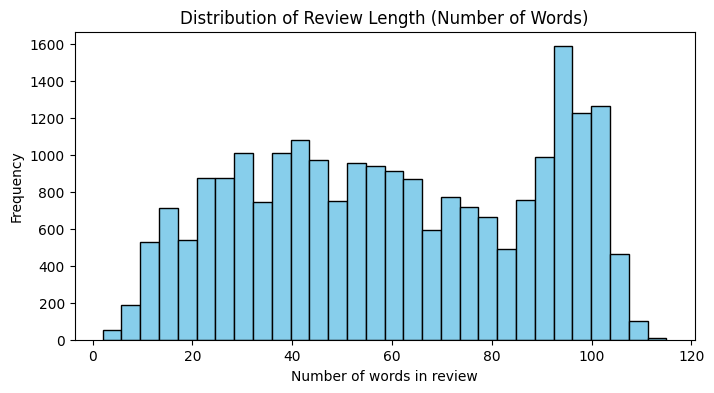

In [13]:
df['review_length'] = df['review_text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,4))
plt.hist(df['review_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Length (Number of Words)')
plt.xlabel('Number of words in review')
plt.ylabel('Frequency')
plt.show()

### One-Hot Encoding for Categorical Variables

To use categorical features in machine learning models, we convert them into binary format using one-hot encoding. This step ensures that our model can interpret and learn from features such as 'division_name', 'department_name', and 'class_name'.

In [14]:
df = pd.get_dummies(df, columns=['division_name', 'department_name', 'class_name'], drop_first=True)

### TF-IDF Vectorization

We apply TF-IDF to the review text to convert unstructured text data into numerical form. This method helps highlight the most relevant words in customer feedback for the classification task.

In [15]:
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = tfidf.fit_transform(df['review_text'])

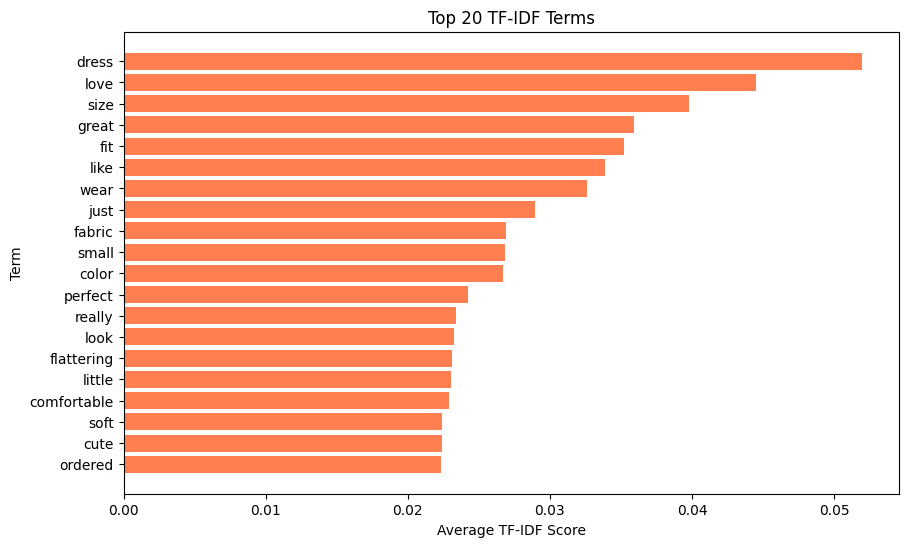

In [16]:
import numpy as np

tfidf_means = np.asarray(X_tfidf.mean(axis=0)).ravel()
terms = tfidf.get_feature_names_out()

# convert to DataFrame for easier handling
tfidf_df = pd.DataFrame({'term': terms, 'tfidf': tfidf_means})

# top 20 TF-IDF terms
top_tfidf = tfidf_df.sort_values(by='tfidf', ascending=False).head(20)

# plot
plt.figure(figsize=(10,6))
plt.barh(top_tfidf['term'][::-1], top_tfidf['tfidf'][::-1], color='coral')
plt.title('Top 20 TF-IDF Terms')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Term')
plt.show()

In [17]:
# Save data for the next steps
df.to_csv('FE_reviews.csv', index=False)

## Feature Selection |Correlation-based feature removal | Random Forest Feature Importance | Mutual Information | 

In [37]:
import pandas as pd

# Load the data
df = pd.read_csv('FE_reviews.csv')

# Check data
print(df.shape)
df.head()

(22641, 35)


,unnamed:_0,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,review_length,division_name_General Petite,...,class_name_Legwear,class_name_Lounge,class_name_Outerwear,class_name_Pants,class_name_Shorts,class_name_Skirts,class_name_Sleep,class_name_Sweaters,class_name_Swim,class_name_Trend
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,8,False,...,False,False,False,False,False,False,False,False,False,False
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,62,False,...,False,False,False,False,False,False,False,False,False,False
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,98,False,...,False,False,False,False,False,False,False,False,False,False
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,22,True,...,False,False,False,True,False,False,False,False,False,False
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,36,False,...,False,False,False,False,False,False,False,False,False,False


In [38]:
# check data type sand see
print(X_structured.dtypes)

non_numeric_cols = X_structured.select_dtypes(exclude=[np.number]).columns.tolist()
print("Non-numeric columns:", non_numeric_cols)


unnamed:_0                      int64
clothing_id                     int64
age                             int64
rating                          int64
positive_feedback_count         int64
review_length                   int64
division_name_General Petite    int32
division_name_Initmates         int32
department_name_Dresses         int32
department_name_Intimate        int32
department_name_Jackets         int32
department_name_Tops            int32
department_name_Trend           int32
class_name_Casual bottoms       int32
class_name_Chemises             int32
class_name_Dresses              int32
class_name_Fine gauge           int32
class_name_Intimates            int32
class_name_Jackets              int32
class_name_Jeans                int32
class_name_Knits                int32
class_name_Layering             int32
class_name_Legwear              int32
class_name_Lounge               int32
class_name_Outerwear            int32
class_name_Pants                int32
class_name_S

In [39]:
y = df['recommended_ind']
X_structured = df.drop(columns=['review_text', 'recommended_ind'], errors='ignore')

# drop the non-numeric 'title' column if present
X_structured = X_structured.drop(columns=['title'], errors='ignore')

# convert boolean columns to integers (true/false - 1/0)
for col in X_structured.columns:
    if X_structured[col].dtype == 'bool':
        X_structured[col] = X_structured[col].astype(int)
        

# scale structured data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_structured_scaled = scaler.fit_transform(X_structured)

# prepare TF-IdF matrix, (textual data)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = tfidf.fit_transform(df['review_text'].fillna(''))  # Handle missing text with fillna

# combine structured and Text features
from scipy.sparse import hstack

import numpy as np
X_combined = hstack([X_structured_scaled, X_tfidf])
print(f"Shape of structured data: {X_structured_scaled.shape}")
print(f"Shape of TF-IDF data: {X_tfidf.shape}")
print(f"Shape of combined data: {X_combined.shape}")

Shape of structured data: (22641, 32)
Shape of TF-IDF data: (22641, 1000)
Shape of combined data: (22641, 1032)


In [42]:
X_structured_df = pd.DataFrame(X_structured_scaled, columns=X_structured.columns)

# correlation matrix
corr_matrix = X_structured_df.corr().abs()  # absolute correlation

# upper tria. no duplicate pairs
import numpy as np

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# find features with correlation more than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

print(f"Highly correlated features to drop: {to_drop}")

# drop these features
X_structured_df_selected = X_structured_df.drop(columns=to_drop)

# recombine with TF-IdF
from scipy.sparse import hstack

X_combined_selected = hstack([X_structured_df_selected.values, X_tfidf])

print(f"New shape of structured data after feature selection: {X_structured_df_selected.shape}")
print(f"New shape of combined data after feature selection: {X_combined_selected.shape}")

Highly correlated features to drop: ['department_name_Intimate', 'class_name_Dresses', 'class_name_Jackets', 'class_name_Trend']
New shape of structured data after feature selection: (22641, 28)
New shape of combined data after feature selection: (22641, 1028)


In [43]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# fit Random forest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_combined_selected, y)

# get feature importances
importances = rf_selector.feature_importances_

# take top 300 featueres
N = 300
indices = np.argsort(importances)[-N:]

# take those features
from scipy.sparse import csr_matrix

X_rf_selected = csr_matrix(X_combined_selected)[:, indices]

print(f"Shape after Random Forest feature selection: {X_rf_selected.shape}")

Shape after Random Forest feature selection: (22641, 300)


Used Random forest to select the top 300 most important features based on feature importance scores.

In [44]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Mutual information feature selection
k = 300  # take top 300 features
mi_selector = SelectKBest(mutual_info_classif, k=k)
X_mi_selected = mi_selector.fit_transform(X_combined_selected, y)

print(f"Shape after Mutual Information feature selection: {X_mi_selected.shape}")

C:\Users\Bhupender\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\Bhupender\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\Bhupender\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\Bhupender\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expec

Shape after Mutual Information feature selection: (22641, 300)


C:\Users\Bhupender\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\Bhupender\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\Bhupender\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\Bhupender\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expec

Applied mutual information to select features that have the strongest dependency with the target variable.

## Model Building/Training

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train/test split
X_train_rf, X_test_rf, y_train, y_test = train_test_split(X_rf_selected, y, test_size=0.2, random_state=42, stratify=y)

# Random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train)

# predictions
y_pred_rf = rf_model.predict(X_test_rf)
y_proba_rf = rf_model.predict_proba(X_test_rf)[:, 1]

# evaluation
print("Random Forest Feature Selection Results:")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print(f'ROC AUC Score: {roc_auc_score(y_test, y_proba_rf):.4f}')

Random Forest Feature Selection Results:
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84       820
           1       0.97      0.95      0.96      3709

    accuracy                           0.94      4529
   macro avg       0.89      0.92      0.90      4529
weighted avg       0.94      0.94      0.94      4529

ROC AUC Score: 0.9724


In [46]:
# Train/test split
X_train_mi, X_test_mi, _, _ = train_test_split(X_mi_selected, y, test_size=0.2, random_state=42, stratify=y)

# Random forest model
rf_model_mi = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_mi.fit(X_train_mi, y_train)

# predictions
y_pred_mi = rf_model_mi.predict(X_test_mi)
y_proba_mi = rf_model_mi.predict_proba(X_test_mi)[:, 1]

# evaluation
print("mutual info feat selection output:")
print("classification Report:\n", classification_report(y_test, y_pred_mi))
print(f'ROC AUC Score: {roc_auc_score(y_test, y_proba_mi):.4f}')

mutual info feat selection output:
classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       820
           1       0.97      0.95      0.96      3709

    accuracy                           0.94      4529
   macro avg       0.89      0.92      0.90      4529
weighted avg       0.94      0.94      0.94      4529

ROC AUC Score: 0.9729


Plotingg roc curves to visually compare the classification performance of both models based on different feature selection techniques. and extract,save the feature importance scores from the random forest model to identify which features contributed most to the predictions.

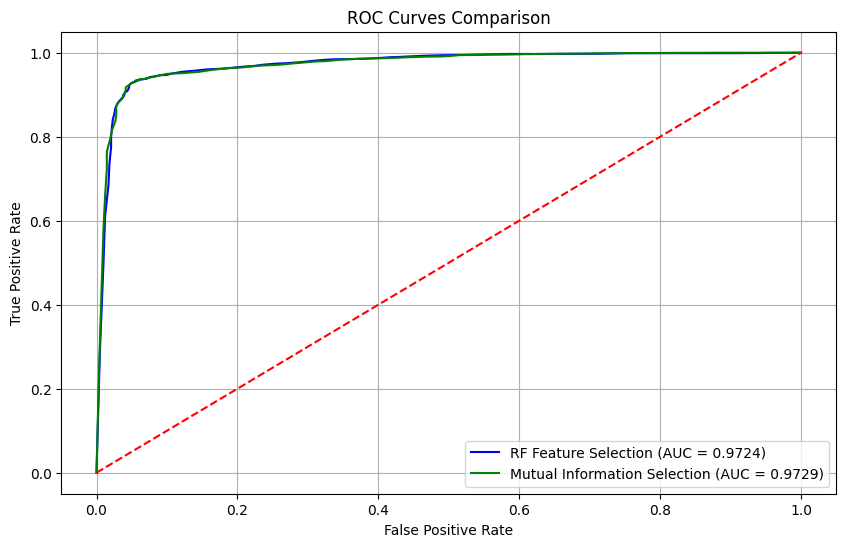

In [47]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# roc curve for Random forest (feature importancee)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# ROC curve for random forest (mutual information)
fpr_mi, tpr_mi, _ = roc_curve(y_test, y_proba_mi)
roc_auc_mi = auc(fpr_mi, tpr_mi)

# plot
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'RF Feature Selection (AUC = {roc_auc_rf:.4f})')
plt.plot(fpr_mi, tpr_mi, color='green', label=f'Mutual Information Selection (AUC = {roc_auc_mi:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [48]:
# export feature importances
feature_importances = rf_model.feature_importances_

import pandas as pd
feature_importances_df = pd.DataFrame({
    'Feature Index': indices,
    'Importance': feature_importances
})

# sorting by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# save 
print(feature_importances_df.head(10))
feature_importances_df.to_csv('feature_importances_rf.csv', index=False)

     Feature Index  Importance
299              3    0.461439
298            266    0.014388
297            700    0.011540
296            510    0.010468
291              5    0.009885
290            961    0.009742
288              0    0.009508
287              1    0.009172
294            518    0.009169
293            701    0.009113
